In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import csv
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf

2024-05-06 03:13:11.766633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 03:13:11.766656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 03:13:11.767357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
import numpy as np

fname = "archive/creditcard.csv"

all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
targets = keras.utils.to_categorical(targets)

num_samples = features.shape[0]
indices = np.random.permutation(num_samples)
shuffled_features = features[indices]
shuffled_targets = targets[indices]

print("shuffled_features.shape:", shuffled_features.shape)
print("shuffled_targets.shape:", shuffled_targets.shape)


HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
shuffled_features.shape: (284807, 30)
shuffled_targets.shape: (284807, 2)


In [23]:
from sklearn.model_selection import train_test_split
train_features ,val_features ,train_targets ,val_targets = train_test_split(features ,
                                                                            targets , test_size=0.2 , random_state=42)

In [24]:
print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 227845
Number of validation samples: 56962


In [25]:
counts = np.bincount(train_targets[:, 0].astype('int32'))
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[1]
weight_for_1 = 1.0 / counts[0]

Number of positive samples in training data: 227451 (99.83% of total)


In [26]:
train_targets = train_targets.astype('float32')
val_targets = val_targets.astype('float32')
train_features = train_features.astype('float32')
val_features = val_features.astype('float32')



train_targets_onehot = keras.utils.to_categorical(train_targets)
val_targets_onehot = keras.utils.to_categorical(val_targets)




mean = np.mean(train_features, axis=0)



train_features -= mean
val_features -= mean

std = np.std(train_features, axis=0)

train_features /= std
val_features /= std

In [27]:
def calculate_fscore(model, features, targets):
    predictions = model.predict(features)
    predictions = (predictions > 0.5).astype(int)
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    fscore = f1_score(targets, predictions)
    
    return precision, recall, fscore

## With Weight

In [28]:
metrics = [
    # keras.metrics.FalseNegatives(name="fn"),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall"),
    keras.metrics.F1Score(name="f1score"),
]

model_With_Weight = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2),
    ]
)

model_With_Weight.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
    metrics=metrics
)

class_weight = {0: weight_for_0, 1: weight_for_1}

history_With_Weight = model_With_Weight.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
112/112 [==============================] - 1s 5ms/step - loss: 3.2810e-06 - f1score: 0.4436 - val_loss: 0.2729 - val_f1score: 0.5438
Epoch 2/30
112/112 [==============================] - 0s 3ms/step - loss: 1.8473e-06 - f1score: 0.5473 - val_loss: 0.1491 - val_f1score: 0.5633
Epoch 3/30
112/112 [==============================] - 0s 3ms/step - loss: 1.5580e-06 - f1score: 0.5535 - val_loss: 0.1623 - val_f1score: 0.5386
Epoch 4/30
112/112 [==============================] - 0s 3ms/step - loss: 1.3306e-06 - f1score: 0.5406 - val_loss: 0.1182 - val_f1score: 0.5496
Epoch 5/30
112/112 [==============================] - 0s 3ms/step - loss: 1.2638e-06 - f1score: 0.5482 - val_loss: 0.1201 - val_f1score: 0.5392
Epoch 6/30
112/112 [==============================] - 0s 3ms/step - loss: 1.3470e-06 - f1score: 0.5364 - val_loss: 0.1380 - val_f1score: 0.5307
Epoch 7/30
112/112 [==============================] - 0s 3ms/step - loss: 1.0757e-06 - f1score: 0.5501 - val_loss: 0.1022 - val_f1score:

In [29]:
history_With_Weight.history.keys()

dict_keys(['loss', 'f1score', 'val_loss', 'val_f1score'])

In [30]:
# val_recall = history_With_Weight.history['val_recall'][-1]
# val_precision = history_With_Weight.history['val_precision'][-1]
val_f1score = history_With_Weight.history['val_f1score'][-1]

# print("Validation Recall:", val_recall)
# print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1score)

Validation F1 Score: [0.9910319  0.15113351]


## Without Weight

In [31]:
import keras

model_Without_Weight = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2),
    ]
)

model_Without_Weight.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=metrics
)

history_Without_Weight = model_Without_Weight.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    validation_data=(val_features, val_targets),
)

Epoch 1/30
112/112 [==============================] - 2s 5ms/step - loss: 0.0204 - f1score: 0.5303 - val_loss: 0.0038 - val_f1score: 0.4996
Epoch 2/30
112/112 [==============================] - 0s 4ms/step - loss: 0.0037 - f1score: 0.6558 - val_loss: 0.0033 - val_f1score: 0.8988
Epoch 3/30
112/112 [==============================] - 0s 4ms/step - loss: 0.0032 - f1score: 0.8812 - val_loss: 0.0031 - val_f1score: 0.8902
Epoch 4/30
112/112 [==============================] - 0s 4ms/step - loss: 0.0029 - f1score: 0.8762 - val_loss: 0.0033 - val_f1score: 0.9071
Epoch 5/30
112/112 [==============================] - 0s 4ms/step - loss: 0.0028 - f1score: 0.8914 - val_loss: 0.0032 - val_f1score: 0.8998
Epoch 6/30
112/112 [==============================] - 0s 4ms/step - loss: 0.0026 - f1score: 0.9101 - val_loss: 0.0033 - val_f1score: 0.9040
Epoch 7/30
112/112 [==============================] - 0s 4ms/step - loss: 0.0027 - f1score: 0.8969 - val_loss: 0.0036 - val_f1score: 0.8958
Epoch 8/30
112/112 [

In [32]:
# val_recall = history_Without_Weight.history['val_recall'][-1]
# val_precision = history_Without_Weight.history['val_precision'][-1]
val_f1score = history_Without_Weight.history['val_f1score'][-1]

# print("Validation Recall:", val_recall)
# print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1score)

Validation F1 Score: [0.99957794 0.77358496]


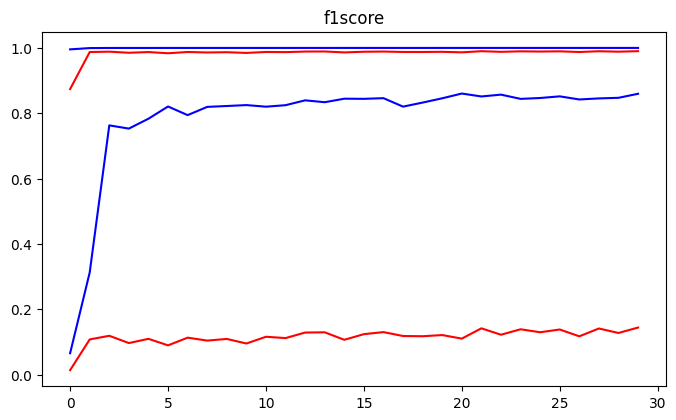

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# plt.subplot(2, 3, 1);plt.plot(history_With_Weight.history['val_recall'], color='red')
# plt.plot(history_Without_Weight.history['val_recall'], color='blue');plt.title('val Recall')

# plt.subplot(2, 3, 2);plt.plot(history_With_Weight.history['val_precision'], color='red')
# plt.plot(history_Without_Weight.history['val_precision'], color='blue');plt.title('val Precision')

# plt.subplot(2, 3, 3);plt.plot(history_With_Weight.history['loss'], color='red')
# plt.plot(history_Without_Weight.history['loss'], color='blue');plt.title('Loss')

# plt.subplot(2, 3, 4);plt.plot(history_With_Weight.history['precision'], color='red')
# plt.plot(history_Without_Weight.history['precision'], color='blue');plt.title('Precision')

# plt.subplot(2, 3, 5);plt.plot(history_With_Weight.history['recall'], color='red')
# plt.plot(history_Without_Weight.history['recall'], color='blue');plt.title('Recall')

plt.subplot(2, 3, 6);plt.plot(history_With_Weight.history['f1score'], color='red')
plt.plot(history_Without_Weight.history['f1score'], color='blue');plt.title('f1score')

plt.tight_layout()
plt.show()

## Without Wight

In [34]:
predictions_without_weight = model_Without_Weight.predict(val_features)
threshold = 0.5
binary_predictions_without_weight = (predictions_without_weight > threshold).astype(int)
print(classification_report(val_targets, binary_predictions_without_weight))

1781/1781 [==============================] - 1s 741us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.69      0.76        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962
 samples avg       1.00      1.00      1.00     56962



/home/syydmr/miniconda3/envs/tf15/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1781/1781 [==============================] - 1s 752us/step


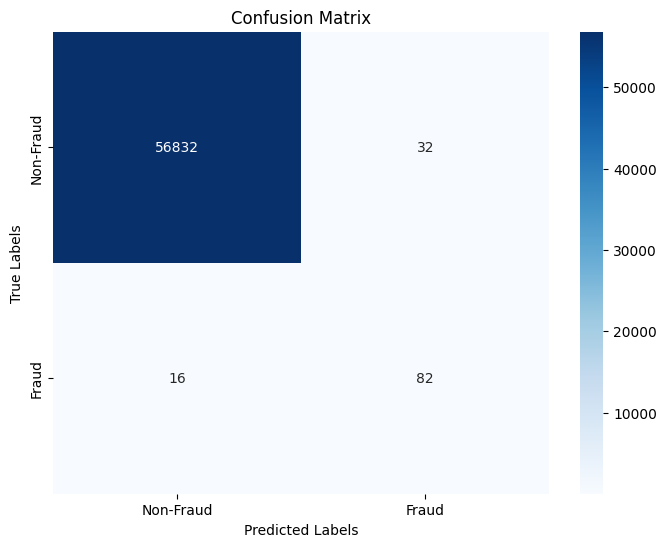

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model_Without_Weight.predict(val_features)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(val_targets, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Fraud", "Fraud"], 
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## With wight

In [36]:
predictions_with_weight = model_With_Weight.predict(val_features)
binary_predictions_with_weight = (predictions_with_weight > threshold).astype(int)
print(classification_report(val_targets, binary_predictions_with_weight))

1781/1781 [==============================] - 1s 754us/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.17      0.92      0.28        98

   micro avg       0.99      0.96      0.98     56962
   macro avg       0.58      0.94      0.63     56962
weighted avg       1.00      0.96      0.98     56962
 samples avg       0.96      0.96      0.96     56962



/home/syydmr/miniconda3/envs/tf15/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1781/1781 [==============================] - 1s 764us/step


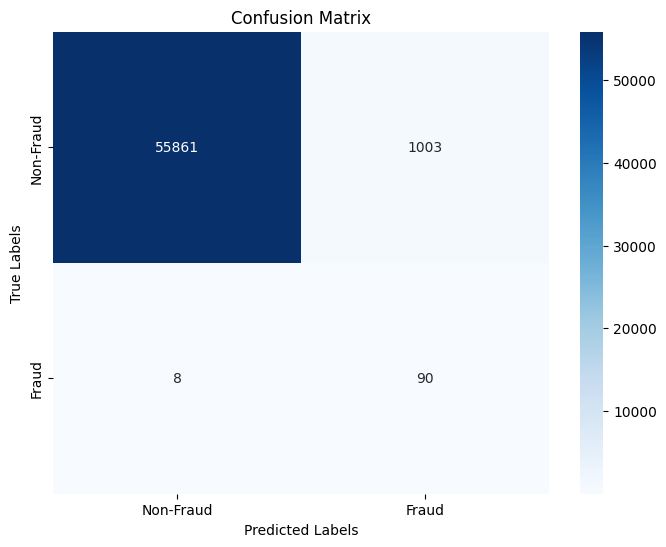

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model_With_Weight.predict(val_features)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(val_targets, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Fraud", "Fraud"], 
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()